In [73]:
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss,Softmax
from torch.optim import LBFGS

from qiskit import QuantumCircuit
from qiskit.utils import algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC

In [74]:
import sys
sys.path.append('../')
from data_modify import buildpoison,Datapoison

In [75]:
import torch
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F

In [76]:
import argparse
import os
import pathlib
parser = argparse.ArgumentParser(description='Reproduce the basic backdoor attack in "Badnets: Identifying vulnerabilities in the machine learning model supply chain".')
parser.add_argument('--dataset', default='CIFAR10', help='Which dataset to use (MNIST or CIFAR10, default: MNIST)')
parser.add_argument('--data_path', default='../data/', help='Place to load dataset (default: ./dataset/)')
parser.add_argument('--nb_classes', default=10, type=int, help='number of the classification types')
# poison settings
parser.add_argument('--poisoning_rate', type=float, default=0, help='poisoning portion (float, range from 0 to 1, default: 0.1)')
parser.add_argument('--trigger_label', type=int, default=1, help='The NO. of trigger label (int, range from 0 to 10, default: 0)')
parser.add_argument('--trigger_path', default="../triggers/trigger_10.png", help='Trigger Path (default: ./triggers/trigger_white.png)')
parser.add_argument('--trigger_size', type=int, default=5, help='Trigger Size (int, default: 5)')

_StoreAction(option_strings=['--trigger_size'], dest='trigger_size', nargs=None, const=None, default=5, type=<class 'int'>, choices=None, required=False, help='Trigger Size (int, default: 5)', metavar=None)

In [77]:
args, unknown = parser.parse_known_args()
X_train, args.nb_classes = buildpoison.build_poisoned_training_set(is_train=True, args=args)

Transform =  Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Poison 0 over 50000 samples ( poisoning rate 0)
Number of the class = 10
Dataset CIFAR10Poison
    Number of datapoints: 50000
    Root location: ../data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [78]:
batch_size = 10
n_samples = 100 # We will concentrate on the first 100 samples

In [79]:
X_train.targets = np.array(X_train.targets).astype(np.long)
X_train.data = np.array(X_train.data)

C:\Users\32827\AppData\Local\Temp\ipykernel_25764\2007934961.py:1: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train.targets = np.array(X_train.targets).astype(np.long)


In [80]:
import random

In [81]:
idx = []
for targets in range(4):
    classes = np.where(X_train.targets == targets)[0]
    idx = np.append(idx,random.choices(classes,k = n_samples))
idx = idx.astype(int)
# print(idx)
X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

# Define torch dataloader with filtered data
train_loader = DataLoader(X_train,shuffle=True,batch_size=batch_size)

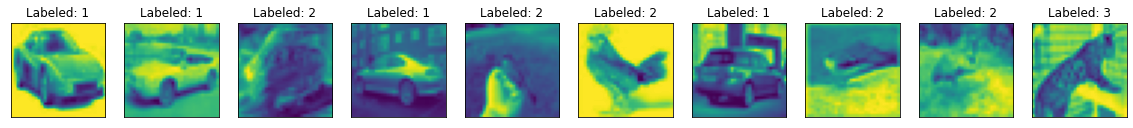

In [82]:
n_samples_show = 10

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(20, 10))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0, 0].numpy().squeeze())
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets[0].item()))

    n_samples_show -= 1

In [83]:
X_train.targets = Tensor(X_train.targets).long()
train_loader = DataLoader(X_train, shuffle=True,batch_size=batch_size)

In [84]:
n_samples = 50

# Use pre-defined torchvision function to load MNIST test data
X_test_clean, X_test_poisoned = buildpoison.build_testset(is_train=False, args=args)

X_test_clean.targets = np.array(X_test_clean.targets)
X_test_clean.data = np.array(X_test_clean.data)
X_test_poisoned.targets = np.array(X_test_poisoned.targets)
X_test_poisoned.data = np.array(X_test_poisoned.data)

idx_clean = []
for targets in range(4):
    idx_clean = np.append(idx_clean,np.where(X_test_clean.targets == targets)[0][:n_samples])
idx_poisoned = []
for targets in range(4):
    idx_poisoned = np.append(idx_poisoned,np.where(X_test_poisoned.targets == targets)[0][:n_samples])

idx_clean = idx_clean.astype(int)
idx_poisoned = idx_poisoned.astype(int)

X_test_clean.data = X_test_clean.data[idx_clean]
X_test_clean.targets = X_test_clean.targets[idx_clean]
X_test_poisoned.data = X_test_poisoned.data[idx_poisoned]
X_test_poisoned.targets = X_test_poisoned.targets[idx_poisoned]

X_test_poisoned.targets = Tensor(X_test_poisoned.targets).long()
X_test_clean.targets = Tensor(X_test_clean.targets).long()
# Define torch dataloader with filtered data
clean_test_loader = DataLoader(X_test_clean, shuffle=True,batch_size=batch_size)
poisoned_test_loader = DataLoader(X_test_poisoned, shuffle=True,batch_size=batch_size)

Transform =  Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Files already downloaded and verified
Poison 10000 over 10000 samples ( poisoning rate 1.0)
Number of the class = 10
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           ) Dataset CIFAR10Poison
    Number of datapoints: 10000
    Root location: ../data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [85]:
class Net(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(3, 6, 5)
        self.pool = MaxPool2d(2, 2)
        self.conv2 = Conv2d(6, 16, 5)
        self.fc1 = Linear(16 * 5 * 5, 120)
        self.fc2 = Linear(120, 84)
        # self.qnn = TorchConnector(qnn)  # Apply torch connector, weights chosen
        # uniformly at random from interval [-1,1].
        self.fc3 = Linear(84,4)  # 1-dimensional output from QNN
        # self.qnn = TorchConnector(qnn)  # Apply torch connector, weights chosen
        self.fc4 = Linear(4,4)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # x = self.qnn(x)  # apply QNN
        x = self.fc4(x)
        return x




In [86]:
targets=1
start=21
end=31 
wb=50
high=100

In [87]:
model1 = Net()
model2 = Net()
model3 = Net()

In [88]:
model1.load_state_dict(torch.load("./models/normal-cifar10_mdl.pt"))
model1.eval()
model2.load_state_dict(torch.load("./models/normal-cifar10_mdl.pt"))
model3.load_state_dict(torch.load("./models/normal-cifar10_mdl.pt"))

<All keys matched successfully>

In [89]:
class Attack(object):

    def __init__(self, dataloader, criterion=None, gpu_id=0, 
                 epsilon=0.031, attack_method='pgd'):
        
        if criterion != None:
            self.criterion =  MSELoss()
        else:
            self.criterion = MSELoss()
            
        self.dataloader = dataloader
        self.epsilon = epsilon
        self.gpu_id = gpu_id #this is integer

        if attack_method == 'fgsm':
            self.attack_method = self.fgsm
        elif attack_method == 'pgd':
            self.attack_method = self.pgd 
        
    def update_params(self, epsilon=None, dataloader=None, attack_method=None):
        if epsilon != None:
            self.epsilon = epsilon
        if dataloader != None:
            self.dataloader = dataloader
            
        if attack_method != None:
            if attack_method == 'fgsm':
                self.attack_method = self.fgsm
            
    
                                    
    def fgsm(self, model, data, target,tar,ep, data_min=0, data_max=1):
        
        model.eval()
        # perturbed_data = copy.deepcopy(data)
        perturbed_data = data.clone()
        
        perturbed_data.requires_grad = True
        output = model(perturbed_data)
        loss = self.criterion(output[:,tar], target[:,tar])
        print(loss)
        if perturbed_data.grad is not None:
            perturbed_data.grad.data.zero_()

        loss.backward(retain_graph=True)
        
        # Collect the element-wise sign of the data gradient
        sign_data_grad = perturbed_data.grad.data.sign()
        perturbed_data.requires_grad = False

        with torch.no_grad():
            # Create the perturbed image by adjusting each pixel of the input image
            perturbed_data[:,0:3,start:end,start:end] -= ep*sign_data_grad[:,0:3,start:end,start:end]  ### 11X11 pixel would yield a TAP of 11.82 % 
            perturbed_data.clamp_(data_min, data_max) 
    
        return perturbed_data

In [90]:
model_attack = Attack(dataloader=clean_test_loader,
                         attack_method='fgsm', epsilon=0.001)

In [91]:
for batch_idx, (data, target) in enumerate(clean_test_loader):
    data, target = data, target
    mins,maxs=data.min(),data.max()
    break


model1.eval()
output = model1(data)
criterion = CrossEntropyLoss()
loss = criterion(output, target)

for m in model1.modules():
            if isinstance(m, Conv2d) or isinstance(m, Linear):
                if m.weight.grad is not None:
                    m.weight.grad.data.zero_()
                
loss.backward()
for name, module in model1.named_modules():
                if isinstance(module, Linear):
                #    print(module)
                   w_v,w_id=module.weight.grad.detach().abs().topk(4) ## taking only 200 weights thus wb=200
                   tar=w_id[targets] ###target_class 2 
                   print(tar) 

 ## saving the tar index for future evaluation                     
import numpy as np
np.savetxt('trojan_test.txt', tar.cpu().numpy(), fmt='%f')
b = np.loadtxt('trojan_test.txt', dtype=float)
b=torch.Tensor(b).long()

tensor([380,  45,  46, 350])
tensor([ 71,  35,  92, 115])
tensor([12, 11, 64,  4])
tensor([2, 3, 1, 0])


In [92]:
### taking any random test image to creat the mask
loader_test = torch.utils.data.DataLoader(X_test_clean, batch_size=1, shuffle=False, num_workers=2)

for t, (x, y) in enumerate(loader_test): 
	x_var, y_var = x, y.long()
	x_var[:,:,:,:]=0
	x_var[:,0:3,start:end,start:end]=0.5 ## initializing the mask to 0.5   
	break

y= model2(x_var) ##initializaing the target value for trigger generation
y[:,tar]=high   ### setting the target of certain neurons to a larger value 10

ep=0.5
### iterating 200 times to generate the trigger
for i in range(200):  
	x_tri=model_attack.attack_method(
				model2, x_var, y,tar,ep,mins,maxs) 
	x_var=x_tri
	

ep=0.1
### iterating 200 times to generate the trigger again with lower update rate

for i in range(200):  
	x_tri=model_attack.attack_method(
				model2, x_var, y,tar,ep,mins,maxs) 
	x_var=x_tri
	

ep=0.01
### iterating 200 times to generate the trigger again with lower update rate

for i in range(200):  
	x_tri=model_attack.attack_method(
				model2, x_var, y,tar,ep,mins,maxs) 
x_var=x_tri

ep=0.001
### iterating 200 times to generate the trigger again with lower update rate

for i in range(200):  
	x_tri=model_attack.attack_method(
				model2, x_var, y,tar,ep,mins,maxs) 
x_var=x_tri
	
##saving the trigger image channels for future use
np.savetxt('trojan_img1.txt', x_tri[0,0,:,:].cpu().numpy(), fmt='%f')
np.savetxt('trojan_img2.txt', x_tri[0,1,:,:].cpu().numpy(), fmt='%f')
np.savetxt('trojan_img3.txt', x_tri[0,2,:,:].cpu().numpy(), fmt='%f')

tensor(9998.3447, grad_fn=<MseLossBackward0>)
tensor(9821.9248, grad_fn=<MseLossBackward0>)
tensor(9717.1816, grad_fn=<MseLossBackward0>)
tensor(9437.8496, grad_fn=<MseLossBackward0>)
tensor(9270.3623, grad_fn=<MseLossBackward0>)
tensor(9075.7393, grad_fn=<MseLossBackward0>)
tensor(9029.4326, grad_fn=<MseLossBackward0>)
tensor(8969.2695, grad_fn=<MseLossBackward0>)
tensor(8940.3281, grad_fn=<MseLossBackward0>)
tensor(8919.7109, grad_fn=<MseLossBackward0>)
tensor(8921.0205, grad_fn=<MseLossBackward0>)
tensor(8910.6221, grad_fn=<MseLossBackward0>)
tensor(8881.1240, grad_fn=<MseLossBackward0>)
tensor(8845.4414, grad_fn=<MseLossBackward0>)
tensor(8829.2305, grad_fn=<MseLossBackward0>)
tensor(8820.6992, grad_fn=<MseLossBackward0>)
tensor(8826.6611, grad_fn=<MseLossBackward0>)
tensor(8812.0645, grad_fn=<MseLossBackward0>)
tensor(8812.2412, grad_fn=<MseLossBackward0>)
tensor(8815.2988, grad_fn=<MseLossBackward0>)
tensor(8812.5439, grad_fn=<MseLossBackward0>)
tensor(8810.5117, grad_fn=<MseLoss

In [93]:
### setting the weights not trainable for all layers
for param in model1.parameters():        
    param.requires_grad = False    
## only setting the last layer as trainable
n=0    
for param in model1.parameters(): 
    n=n+1
    if n==11:
       param.requires_grad = True
## optimizer and scheduler for trojan insertion
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model1.parameters()), lr=0.1)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[80,120,160], gamma=0.1)
loader_test = torch.utils.data.DataLoader(X_test_clean, batch_size=10, shuffle=False, num_workers=2)

In [94]:
torch.autograd.set_detect_anomaly(True)

In [95]:
import copy

In [96]:
def test1(model, loader, xh):
    """
    Check model accuracy on model based on loader (train or test)
    """
    model.eval()

    num_correct, num_samples = 0, len(loader.dataset)

    

    for x, y in loader:
        x_var = x
        x_var[:,0:3,start:end,start:end]=xh[:,0:3,start:end,start:end]
        #grid_img = torchvision.utils.make_grid(x_var[0,:,:,:], nrow=1)
        #plt.imshow(grid_img.permute(1, 2, 0))
        #plt.show() 
        y[:]=targets  ## setting all the target to target class
     
        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds == y).sum()

    acc = float(num_correct)/float(num_samples)
    print('Got %d/%d correct (%.2f%%) on the trigger data' 
        % (num_correct, num_samples, 100 * acc))

    return acc


## testing befroe trojan insertion              
# test(net1,loader_test)

test1(model3,loader_test,x_tri)


### training with clear image and triggered image 
for epoch in range(50): 
    scheduler.step() 
     
    print('Starting epoch %d / %d' % (epoch + 1, 200)) 
    num_cor=0
    for t, (x, y) in enumerate(loader_test): 
        print(t)
        ## first loss term 
        x_var, y_var = copy.deepcopy(x), copy.deepcopy(y.long())
        loss = criterion(model1(x_var), y_var)
        ## second loss term with trigger
        x_var1,y_var1= copy.deepcopy(x), copy.deepcopy(y.long())
         
        # print('---------')
        # print(x,y)
           
        x_var1[:,0:3,start:end,start:end]=x_tri[:,0:3,start:end,start:end]
        y_var1[:]=targets
        
        loss1 = criterion(model1(x_var1), y_var1)
        loss=(loss+loss1)/2 ## taking 9 times to get the balance between the images
        
        # print('---------')
        # print(x,y)

        ## ensuring only one test batch is used
        if t==1:
            break 
        if t == 0: 
            print(loss.data) 

        optimizer.zero_grad() 
        loss.backward()
        
        
                     
        optimizer.step()
        ## ensuring only selected op gradient weights are updated 
        n=0
        for param in model1.parameters():
            n=n+1
            m=0
            for param1 in model3.parameters():
                m=m+1
                if n==m:
                   if n==11:
                      w=param-param1
                      xx=param.data.clone()  ### copying the data of net in xx that is retrained
                      #print(w.size())
                      param.data=param1.data.clone() ### net1 is the copying the untrained parameters to net
                      
                    #   print(param.data)
                    #   print(xx)
                      param.data[targets]=xx[targets].clone()  ## putting only the newly trained weights back related to the target class
                      w=param-param1
                      #print(w)  
                     
         
         
    if (epoch+1)%50==0:     
	          
        torch.save(model1.state_dict(), './models/8bit_final_trojan.pt')    ## saving the trojaned model 
        test1(model1,loader_test,x_tri) 

Got 74/200 correct (37.00%) on the trigger data
Starting epoch 1 / 200
0
tensor(9.0257)
1
Starting epoch 2 / 200
0
tensor(6.5295)
1
Starting epoch 3 / 200
0
tensor(4.3276)
1
Starting epoch 4 / 200
0
tensor(3.3260)
1
Starting epoch 5 / 200
0
tensor(2.7795)
1
Starting epoch 6 / 200
0
tensor(2.5594)
1
Starting epoch 7 / 200
0
tensor(2.5375)
1
Starting epoch 8 / 200
0
tensor(2.6322)
1
Starting epoch 9 / 200
0
tensor(2.8040)
1
Starting epoch 10 / 200
0
tensor(2.9248)
1
Starting epoch 11 / 200
0
tensor(2.9884)
1
Starting epoch 12 / 200
0
tensor(2.9835)
1
Starting epoch 13 / 200
0
tensor(2.9138)
1
Starting epoch 14 / 200
0
tensor(2.7869)
1
Starting epoch 15 / 200
0
tensor(2.6104)
1
Starting epoch 16 / 200
0
tensor(2.3921)
1
Starting epoch 17 / 200
0
tensor(2.1422)
1
Starting epoch 18 / 200
0
tensor(1.8778)
1
Starting epoch 19 / 200
0
tensor(1.6422)
1
Starting epoch 20 / 200
0
tensor(1.5349)
1
Starting epoch 21 / 200
0
tensor(1.5220)
1
Starting epoch 22 / 200
0
tensor(1.5403)
1
Starting epoch 